# Assignment 1: Classification

### Programme
- IC502
-  MSc Artificial Intelligence	

### Module
- Module Code: SIS 6117
- Module Name: Machine Learning

##### Student
- ID: 2023146
- Name: Kherin Bundhoo

## Table Of Contents

- ### Overview
- ### Loading data
- ### Visualization
- ### Data Preprocessing
- ### Feature Extraction
- ### Classifiers:
    - #### Naive Bayes
    - #### Decision Trees
    - #### K-Nearest Neighbor
    - #### Support Vector Machines
- ### Evaluation of Models
    - #### Confusion Matrix
- ### Conclusion
- ### References

In [1]:
# importing required libraries

import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.classifier import ClassificationReport

import nltk
nltk.download('punkt', download_dir='.')
from nltk.stem import PorterStemmer

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

[nltk_data] Downloading package punkt to ....
[nltk_data]   Package punkt is already up-to-date!


# Overview

The current Jupyter notebook illustrates the conception of several classification models. Those models are then evaluated based on their performance while executing the same goal: *classification of IT Support Ticktets* on a given dataset. 

Each ticket is comprised of a short description of an issue being faced by an end-user while utilising a particular IT service. Those issues varies in root causes and can only be handled by specific teams.

Hence, in a large corporation, with domain-specific teams, the automation of the IT Support Tickets represents a real business advantage.

*Note: More details about the business value are captured in the related report*

# Load data

Using pandas to loading data from a csv file (*raw.csv*) containing categorized descriptions of it tickets

In [2]:
# Loading Data
df = pd.read_csv("datasets/raw.csv")

# Visualization

Displaying the 10 first and last rows of the raw dataset from the dataframe

In [3]:
df.head(10) # displays 10 first rows

,description,category
0,Hi since recruiter lead permission approve req...,Application
1,re expire days Hi ask help update passwords co...,Application
2,verification warning Hi has got attached Pleas...,Application
3,Please dear looks blacklisted receiving mails ...,Application
4,dear modules report report cost thank much reg...,Application
5,Please action reports dear way help close thes...,Application
6,Hello Please fill date.,Application
7,secondary Hi Please provide secondary ledger u...,Application
8,copy Hi receive copy behavior expect receive m...,Application
9,invitation strategy workshop february manchest...,Application


In [4]:
df.tail(10) # displays 10 last rows

,description,category
2990,sent monday printer issues Hi xerox printer ac...,Database
2991,sent tuesday re notification upgrade la thanks...,Database
2992,sent monday re sporadically send certain invit...,Database
2993,one plastic pieces covering hinge keeps screen...,Database
2994,sent friday problem data aud sica sa sa data s...,Database
2995,sent tuesday feedback follow up! conf call Hel...,Database
2996,sent monday issues Hi keep getting errors whil...,Database
2997,sent monday en working properly Hi guys we hav...,Database
2998,sent wednesday july Hi; Please log incident fo...,Database
2999,sent tuesday july connection issues Hello have...,Database


Counting the rows for each Category of IT Support Tickets

Text(0, 0.5, 'Number of rows')

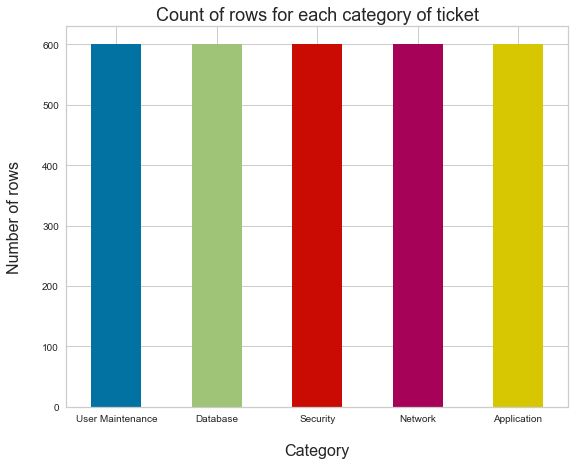

In [5]:
# Visualizing the number of rows for each category
df["category"].value_counts().plot(kind = "bar", figsize=(9, 7), rot=0)

plt.title("Count of rows for each category of ticket", fontsize=18)
plt.xlabel("Category", labelpad=20, fontsize=16)
plt.ylabel("Number of rows", labelpad=20, fontsize=16)

# Data Preprocessing

In the current context, the data preprocessing stage is even more important as the data is user-generated and may contain a large quantity of noise. 

In order to facilitate the training and testing phases, it is required to perform data cleansing by:

-  Standardising the data by transforming every character into lowercase
-  Reducing noise (data of low relevance and quality) by removing punctuations

### Making every character in the dataset lower case

In [6]:
df["description"] = df["description"].map(lambda description_row: description_row.lower())

### Removing punctuations from the dataset

In [7]:
df["description"] = df["description"].map(lambda description_row: description_row.replace("[^\w\s]", ""))

### Tokenization
In this process, each sentence for each description are broken down into individual words.
This will facilitate the manipulation of the dataset during feature extraction.

In [8]:
df["description"] = df["description"].apply(nltk.word_tokenize)

In [9]:
df.head(5)

,description,category
0,"[hi, since, recruiter, lead, permission, appro...",Application
1,"[re, expire, days, hi, ask, help, update, pass...",Application
2,"[verification, warning, hi, has, got, attached...",Application
3,"[please, dear, looks, blacklisted, receiving, ...",Application
4,"[dear, modules, report, report, cost, thank, m...",Application


## Word Stemming

Using word stemming to reduce each word to its word stem

In [10]:
stemmer = PorterStemmer()
df["description"] = df["description"].apply(lambda sentences: [stemmer.stem(word) for word in sentences])
df.head()

,description,category
0,"[hi, sinc, recruit, lead, permiss, approv, req...",Application
1,"[re, expir, day, hi, ask, help, updat, passwor...",Application
2,"[verif, warn, hi, ha, got, attach, pleas, addr...",Application
3,"[pleas, dear, look, blacklist, receiv, mail, a...",Application
4,"[dear, modul, report, report, cost, thank, muc...",Application


Concatenating words back together, separated by a single whitespace

In [11]:
df["description"] = df["description"].apply(lambda sentences: " ".join(sentences))

In [12]:
df.head()

,description,category
0,hi sinc recruit lead permiss approv requisit m...,Application
1,re expir day hi ask help updat password collea...,Application
2,verif warn hi ha got attach pleas address best...,Application
3,pleas dear look blacklist receiv mail anymor s...,Application
4,dear modul report report cost thank much regard .,Application


# Feature Selection

Using a Count Vectorizer to obtain the frequency of each word in the overall dataset

In [13]:
token_count_vect = CountVectorizer()
token_counts = token_count_vect.fit_transform(df["description"])

### Visualizing the most frequently-occurring words 

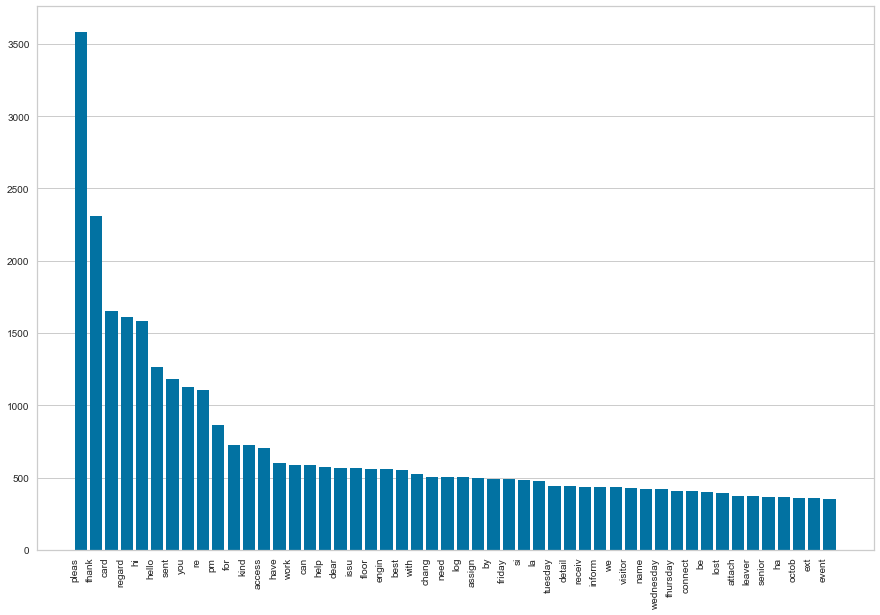

In [14]:
features   = token_count_vect.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v', size=(1080, 720))
visualizer.fit(token_counts);

### Using Term Frequency Inverse Document Frequency
TFIDF is a statistical measure that will help us determine the relevancy of each word throughout the dataset

In [15]:
token_count_transformer = TfidfTransformer().fit(token_counts)
token_counts = token_count_transformer.transform(token_counts)

In [16]:
df_idf = pd.DataFrame(token_count_transformer.idf_, index = token_count_vect.get_feature_names(), columns=["idf_weights"])
df_idf.sort_values(by=["idf_weights"])
df_idf.head(5)

,idf_weights
ab,7.908089
abandon,7.908089
abil,6.927259
abl,5.074875
abnorm,8.313554


# Dataset Splitting

The dataset is split into training batch (80%) and testing batch (20%). This will help gauge better the accuracy after training and detect whether the model if overfitting or not.

In [17]:
description_training, description_testing, category_training, category_testing = train_test_split(token_counts, df["category"], test_size=.2, random_state=69)

# Naive Bayes

The multinomial Naive Bayes classifier (`MultinomialNB`) has been selected as the classifier as it is best-suited for classification of discrete features. In this case, the discrete features are the word_counts for each corresponding category. 

In [18]:
nb_model = MultinomialNB().fit(description_training, category_training)

#### Prediction using Test data
The test data is fed into the classifier and the average of predicted categories which correspond to the actual categories is computed. 

This computed value represents the accuracy of the model.

In [19]:
predicted = nb_model.predict(description_testing)

print("Accuracy of Naive Bayesian Model: %s" %(np.mean(predicted==category_testing)))

Accuracy of Naive Bayesian Model: 0.77


# Decision Trees

In [20]:
clf = DecisionTreeClassifier()
clf = clf.fit(description_training, category_training)
clf_predicted = clf.predict(description_testing)

print("Accuracy of the Decision Trees Model: %s" %(np.mean(clf_predicted==category_testing)))

Accuracy of the Decision Trees Model: 0.6216666666666667


# K-Nearest Neighbor

In [21]:
scaler = StandardScaler(with_mean=False)
scaler.fit(description_training)

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(description_training, category_training)
knn_predicted = classifier.predict(description_testing)

print("Accuracy of the KNN Model: %s" %(np.mean(knn_predicted==category_testing)))

Accuracy of the KNN Model: 0.7283333333333334


# Support Vector Machines

In [22]:
svm_clf = svm.SVC(kernel="linear")
svm_clf.fit(description_training, category_training)
svm_predicted = svm_clf.predict(description_testing)

print("Accuracy of the SVM Model: %s" %(np.mean(svm_predicted==category_testing)))

Accuracy of the SVM Model: 0.7883333333333333


# Evaluation

In the current context,  in order to improve the accuracy of a model and obtain an indication on how to achieve a desirable accuracy, it is important to evaluate the model using evaluation metrics. 

This will also determine the best-suited model for the current scenario.


## Evaluation Metric: 

- *Precision*

Precision can be seen as a measure of a classifier’s exactness.

- *Recall*

Recall is a measure of the classifier’s completeness; the ability of a classifier to correctly find all positive instances.

- *F1 score*

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. 

- *Support*

Support is the number of actual occurrences of the class in the specified dataset.


## Classification Report for: Naive Bayes

In [23]:
print(classification_report(category_testing, predicted));

                  precision    recall  f1-score   support

     Application       0.73      0.81      0.77       117
        Database       0.83      0.72      0.77       122
         Network       0.71      0.66      0.68       117
        Security       0.83      0.78      0.81       129
User Maintenance       0.76      0.88      0.81       115

       micro avg       0.77      0.77      0.77       600
       macro avg       0.77      0.77      0.77       600
    weighted avg       0.77      0.77      0.77       600



## Classification Report for: Decision Trees

In [24]:
print(classification_report(category_testing, clf_predicted));

                  precision    recall  f1-score   support

     Application       0.61      0.56      0.58       117
        Database       0.65      0.59      0.62       122
         Network       0.48      0.51      0.50       117
        Security       0.71      0.67      0.69       129
User Maintenance       0.66      0.77      0.71       115

       micro avg       0.62      0.62      0.62       600
       macro avg       0.62      0.62      0.62       600
    weighted avg       0.62      0.62      0.62       600



## Classification Report for: K-Nearest Neighbor

In [25]:
print(classification_report(category_testing, knn_predicted));

                  precision    recall  f1-score   support

     Application       0.68      0.79      0.73       117
        Database       0.73      0.73      0.73       122
         Network       0.70      0.53      0.60       117
        Security       0.80      0.73      0.76       129
User Maintenance       0.73      0.86      0.79       115

       micro avg       0.73      0.73      0.73       600
       macro avg       0.73      0.73      0.72       600
    weighted avg       0.73      0.73      0.72       600



## Classification Report for: Support Vector Machines

In [26]:
print(classification_report(category_testing, svm_predicted));

                  precision    recall  f1-score   support

     Application       0.71      0.86      0.78       117
        Database       0.79      0.75      0.77       122
         Network       0.75      0.68      0.71       117
        Security       0.91      0.76      0.83       129
User Maintenance       0.80      0.90      0.85       115

       micro avg       0.79      0.79      0.79       600
       macro avg       0.79      0.79      0.79       600
    weighted avg       0.79      0.79      0.79       600



## References & Resources

- https://thesai.org/Downloads/Volume4No11/Paper_5-Performance_Comparison_between_Na%C3%AFve_Bayes.pdf
- https://stackabuse.com/the-naive-bayes-algorithm-in-python-with-scikit-learn/
- https://www.datacamp.com/community/tutorials/decision-tree-classification-python
- https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/
- https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
- https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/